# Unsupervised

In this notebook, I first conduct principal component analysis and fint the most important features. Then I run K-means clustering model and DBSCAN model on both PCs and important features to find what is the best performing model to use to answer my research questions.

In [39]:
#Selected packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans, DBSCAN
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from kneed import KneeLocator
import warnings
warnings.filterwarnings('ignore')  

In [40]:
#Importing data afetr eda
eda_df = pd.read_csv(r"C:\Users\ottok\OneDrive\Documents\AI_resit_EDA.xlsx")
eda_df.head()

,runtime,genre,worldwide_box_office,theatre_count,avg_run_per_theatre,creative_type,seasons
0,104.0,1,108286422.0,3391.0,4.9,1,2
1,100.0,2,987640.0,3.0,2.1,1,4
2,93.0,2,307.0,819.5,4.2,1,1
3,93.0,2,47019.0,819.5,4.2,1,2
4,107.0,2,143782.0,6.0,3.8,2,3


## PCA

Scaling the dataframe

In [41]:
#Defining standard scaler instance
scaler = StandardScaler()

#Fitting the StandardScaler to the entire dataframe
scaler.fit(eda_df)

#Scaling the entire dataframe using the fitted StandardScaler
df_scaled = pd.DataFrame(scaler.transform(eda_df), columns=eda_df.columns)


Finding the principal components

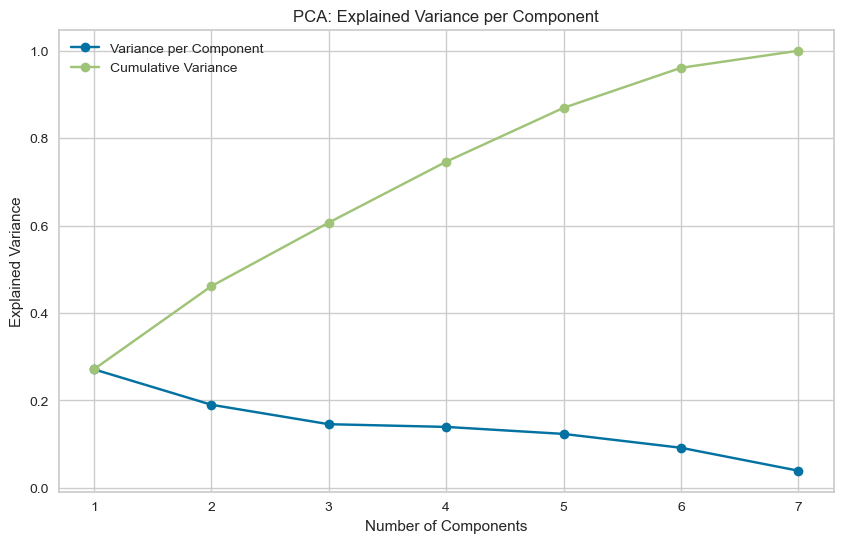

In [42]:
#Performing PCA
pca = PCA()
pca.fit(df_scaled)

#Getting the explained variance ratio
explained_variance = pca.explained_variance_ratio_

#Calculating the cumulative variance
cumulative_variance = np.cumsum(explained_variance)

#Plotting the explained variance ratio and cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Variance per Component')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label='Cumulative Variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA: Explained Variance per Component')
plt.legend()
plt.show()


Now we check how much variance we want to explain, we choose 85%. Then we see how many principal components explain 85% of the variance.

In [43]:
#Let's say we would like to explain 85% variance  
var_exp_thres = 0.85
#Calling Principal components with desired variance explained threshold
pca = PCA(var_exp_thres)  
pca_comps = pca.fit_transform(df_scaled)  
print('Number of components to explain {:0.0f}% variance is {}'.format(var_exp_thres*100, pca.n_components_))

Number of components to explain 85% variance is 5


Now we want to find out the most important features. We use a list comprehension to iterate over each component of the PCA and find the index of the most important feature for that component.

In [44]:
#Getting the index of the most important feature on each component by using list comprehension
most_important_features_idx = [np.abs(pca.components_[i]).argmax() for i in range(pca.n_components_)]
most_important_features = df_scaled.columns[most_important_features_idx]

print('The most important features are:', most_important_features.values)

The most important features are: ['worldwide_box_office' 'runtime' 'seasons' 'seasons' 'creative_type']


We see that the feature 'season' is mentioned twice. Because we find the index of the most important feature for each component, it could be the same for multiple components. This is because the importance of a feature in a component is determined by how much that feature contributes to the variance explained by that component. A feature could contribute significantly to the variance explained by multiple components, and thus be the "most important" feature in those components.

In [45]:
#Checking the scaled dataframe with the most important features
df_scaled[most_important_features].head()

,worldwide_box_office,runtime,seasons,seasons,creative_type
0,1.253119,-0.016945,-0.535458,-0.535458,-0.709711
1,-0.610965,-0.277007,1.261368,1.261368,-0.709711
2,-0.628118,-0.732114,-1.433871,-1.433871,-0.709711
3,-0.627307,-0.732114,-0.535458,-0.535458,-0.709711
4,-0.625626,0.178101,0.362955,0.362955,-0.156474


## K-means clustering

### K-means for PCs

Now we perform K-means clustering for the principal components.

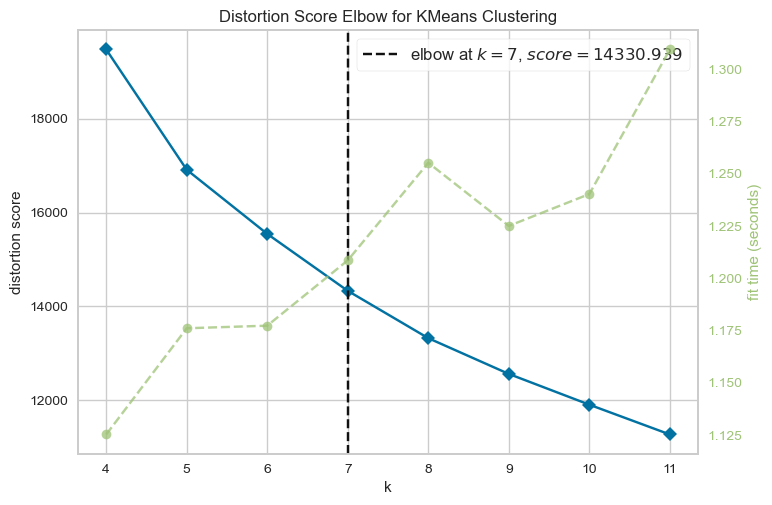

The best cluster number is: 7


In [46]:
#Performing the elbow method and Instantiating the clustering model and visualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(4,12))
visualizer.fit(pca_comps)        #Fitting the important PCA component data to the visualizer
visualizer.show()        #Finalizing and rendering the figure
print('The best cluster number is:', visualizer.elbow_value_) #Getting the elbow value

Fitting the model with the best cluster number

In [47]:
#Instantiating the KMeans model with the best cluster number
kmeans_best_cluster = KMeans(n_clusters=visualizer.elbow_value_)
kmeans_best_cluster.fit(pca_comps) #Fitting the model to the important PCA component data
#Saving the cluster labels
Kmeans_clusters_PCs = kmeans_best_cluster.labels_

### K-means for important features

Finding the best cluster number for Kmeans important features

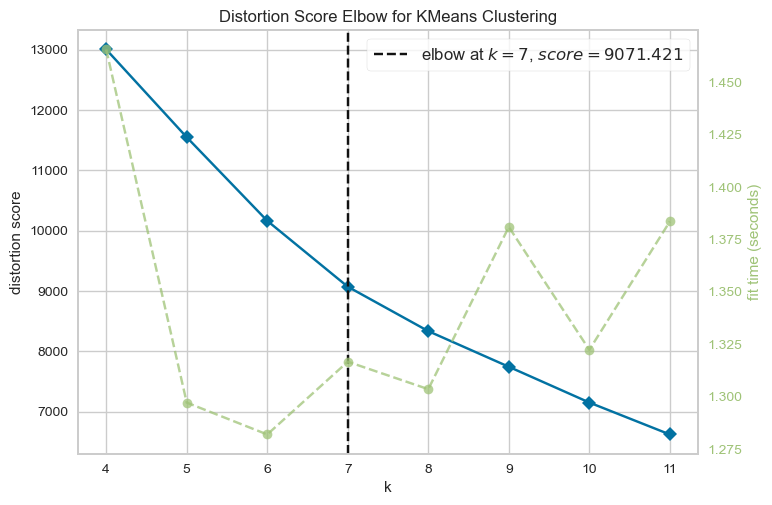

The best cluster number is: 7


In [48]:
#Instantiating the clustering model and visualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(4,12))
visualizer.fit(df_scaled[most_important_features])   #Fitting the important features data to the visualizer
visualizer.show()        #Finalizing and rendering the figure
visualizer.elbow_value_ #Getting elbow value

print('The best cluster number is:', visualizer.elbow_value_)

Fitting the model with the best cluster number

In [49]:
#Instantiating the KMeans model with the best cluster number
kmeans_best_cluster = KMeans(n_clusters=visualizer.elbow_value_)
kmeans_best_cluster.fit(df_scaled[most_important_features]) #Fitting the model to the important features data
#Saving the cluster labels
Kmeans_clusters_ImpFeatures = kmeans_best_cluster.labels_

### Model evaluation

We evaluate the model by using the Silhouette Score and the Davies-Bouldin Score.

1. **Silhouette Score**: This metric calculates the average distance between each sample in a cluster and all other points in the same cluster (cohesion), as well as the average distance between each sample in a cluster and the samples in the next nearest cluster (separation). The Silhouette Score ranges from -1 to 1, where a high value indicates that the sample is well matched to its own cluster and poorly matched to neighboring clusters.

2. **Davies-Bouldin Score**: This metric is an internal evaluation method where a lower Davies-Bouldin index relates to a model with better separation between the clusters. This index signifies the average 'similarity' between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. 

By calculating these scores for the K-means clustering on Principal components and important features, we can evaluate how well the K-means algorithm has performed in creating distinct and meaningful clusters from the data.

In [50]:
#Calculating the silhouette score and the Davied Bouldin score for the K-means clustering on PC components and important features
sc = []
dbi = []

#Metrics from imporant PC features method
sc.append(metrics.silhouette_score(pca_comps, Kmeans_clusters_PCs, metric='euclidean'))
dbi.append(metrics.davies_bouldin_score(pca_comps, Kmeans_clusters_PCs))

#Metrics from imporant features from PCA method
sc.append(metrics.silhouette_score(df_scaled[most_important_features], Kmeans_clusters_ImpFeatures, metric='euclidean'))
dbi.append(metrics.davies_bouldin_score(df_scaled[most_important_features], Kmeans_clusters_ImpFeatures))

clustering_methods = ['Kmean_on_PCs', 'Kmean_on_ImpFeatures']

# Creating a pandas dataframe to see the scores
d = {'silhouette_score': sc, 'DBI': dbi, 'clustering_methods':clustering_methods}
df_metrics = pd.DataFrame(d)
df_metrics.set_index('clustering_methods', inplace = True)
df_metrics

,silhouette_score,DBI
clustering_methods,,
Kmean_on_PCs,0.209544,1.351548
Kmean_on_ImpFeatures,0.286299,1.164633


We can see that Since K-means clustering on important features has a higher Silhoutee score and a lower DBI, it performs better than K-means clustering on principal components.

Next, we will plot 3D visualizations of the clusters with 3 principal components and 3 most important features. This process allows us to visually understand the structure of our data, the performance of our clustering algorithm, and the importance of different features in defining the clusters. It also aids in dimensionality reduction, making high-dimensional data more comprehensible. Furthermore, it assists in outlier detection, helping us identify data points that do not fit well into any cluster. Therefore, this step is crucial for interpreting the results of our analysis and gaining meaningful insights from our data.

Specifically, the below plots show us how the clustering for important features distinguishes the data better than the clustering for principal components.

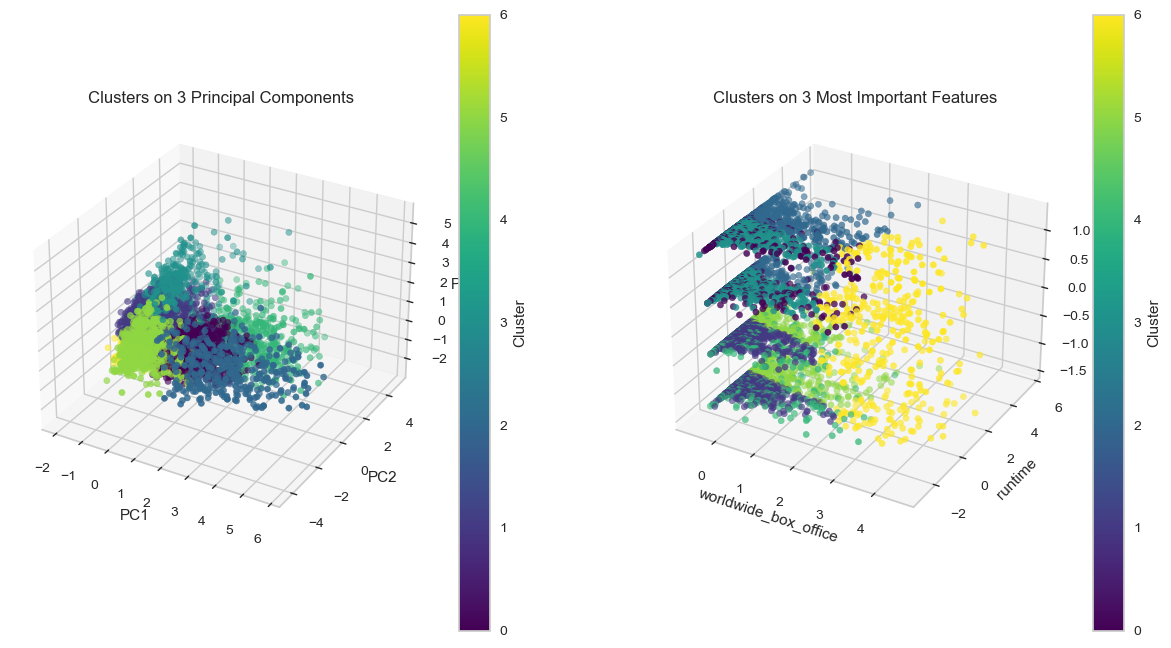

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8), subplot_kw={'projection': '3d'})

# Plotting the clusters on the 3 principal components
scatter1 = axes[0].scatter(pca_comps[:, 0], pca_comps[:, 1], pca_comps[:, 2], c=Kmeans_clusters_PCs, cmap='viridis')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_zlabel('PC3')
axes[0].set_title('Clusters on 3 Principal Components')

# Plotting the clusters on the 3 most important features
scatter2 = axes[1].scatter(df_scaled[most_important_features[0]], df_scaled[most_important_features[1]], df_scaled[most_important_features[2]], c=Kmeans_clusters_ImpFeatures, cmap='viridis')
axes[1].set_xlabel(most_important_features[0])
axes[1].set_ylabel(most_important_features[1])
axes[1].set_zlabel(most_important_features[2])
axes[1].set_title('Clusters on 3 Most Important Features')

# Adding colorbars
cbar1 = fig.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster')
cbar2 = fig.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Cluster')

plt.show()

## DBSCAN

### DBSCAN for PCs

Setting the hyperparameter minimum samples amount is important, beacuse the minimum samples parameter determines the minimum number of samples required for a cluster to be considered valid.

In [52]:
#Setting the minimum samples amount
min_samples = pca_comps.shape[1]*2

#Printing the value of minimum samples
print("Min Samples:", min_samples)

Min Samples: 10


We now perform a nearest neighbors analysis using the k-nearest neighbors algorithm. we calculate the distances between each point and its 11 (same as the minimum samples) nearest neighbors using the k-nearest neighbors algorithm, and then sorts these distances in ascending order. This allows us to find the other hyperparameter epsilon.

In [53]:
#We select n_neighbors = 11 as first column will be zeros (i.e. distance of point to itself) 
nbrs = NearestNeighbors(n_neighbors = 11).fit(pca_comps)
#Finding the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(pca_comps)
#Sorting the neighbor distances (lengths to points) in ascending order
sort_neigh_dist = np.sort(neigh_dist, axis = 0) ##Axis = 0 represents sort along first axis i.e. sort along row

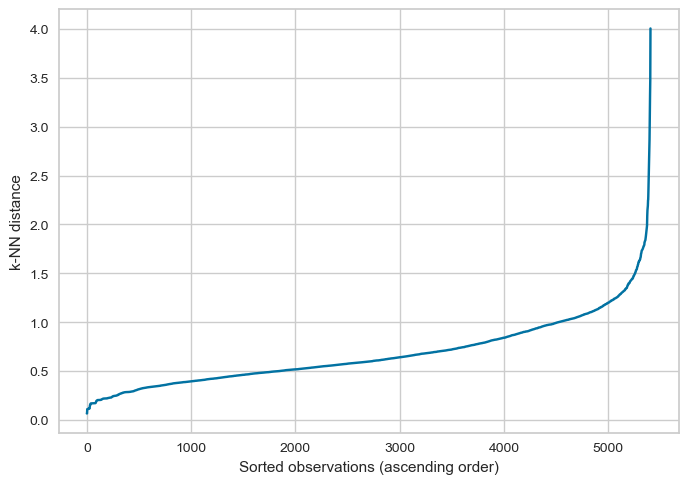

In [54]:
#Plotting the k-NN distance
k_dist = sort_neigh_dist[:, 10]
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (ascending order)")
plt.show()

Now we find the epsilon which is the knee point. Epsilon is a key hyperparameter that defines the radius of the neighborhood around each point.

In [55]:
#Getting the knee point
kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)
#Printing the knee point
print(kneedle.knee_y)

1.7847538239581329


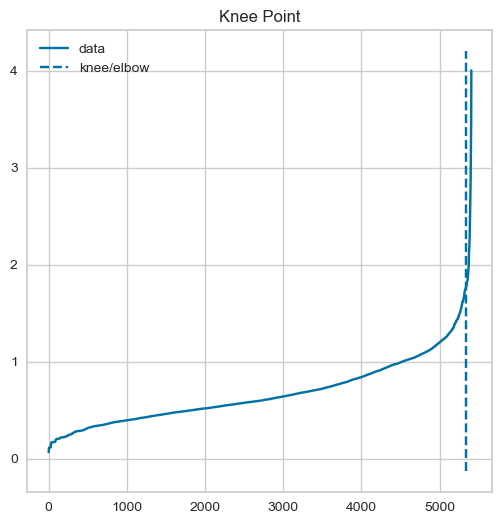

In [56]:
#Visualizing the knee point
kneedle.plot_knee()
plt.show()

Creating the final DBSCAN model with the epsilon found.

In [57]:
#DBSCAN final model
dbscan = DBSCAN(eps = 1.785, min_samples = min_samples)
db_clusters_PCs = dbscan.fit_predict(pca_comps)
print('dbscan has created clusters:', list(set(db_clusters_PCs)))

dbscan has created clusters: [0, -1]


Having only one cluster shows that epsilon might be too large so we will try to reduce it to get more clusters

In [58]:
#DBSCAN final model with a lower epsilon
dbscan = DBSCAN(eps = 1, min_samples = min_samples)
db_clusters_PCs = dbscan.fit_predict(pca_comps)
print('dbscan has created clusters:', list(set(db_clusters_PCs)))

dbscan has created clusters: [0, 1, 2, 3, -1]


### DBSCAN with most important features

Setting the hyperparameter minimum samples amount is important, beacuse the minimum samples parameter determines the minimum number of samples required for a cluster to be considered valid.

In [59]:
#Setting the minimum samples amount
min_samples_2 = df_scaled[most_important_features].shape[1] * 2

#Print the value of minimum samples
print("Min Samples:", min_samples_2)

Min Samples: 10


We now perform a nearest neighbors analysis using the k-nearest neighbors algorithm. we calculate the distances between each point and its 11 (same as the minimum samples) nearest neighbors using the k-nearest neighbors algorithm, and then sorts these distances in ascending order. This allows us to find the other hyperparameter epsilon.

In [60]:
#We select n_neighbors = 11 as first column will be zeros (i.e. distance of point to itself) 
nbrs = NearestNeighbors(n_neighbors = 11).fit(df_scaled[most_important_features])
#Finding the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(df_scaled[most_important_features])
#Sorting the neighbor distances (lengths to points) in ascending order
sort_neigh_dist = np.sort(neigh_dist, axis = 0) #Axis = 0 represents sort along first axis i.e. sort along row

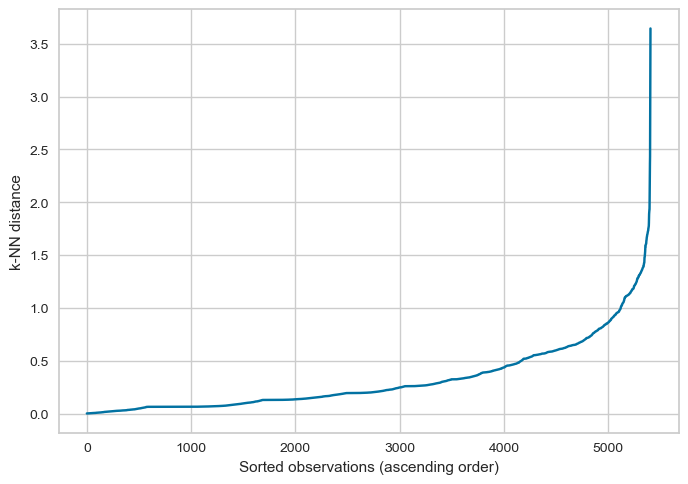

In [61]:
#Plotting the k-NN distance
k_dist = sort_neigh_dist[:, 10]
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (ascending order)")
plt.show()

Now we find the epsilon which is the knee point. Epsilon is a key hyperparameter that defines the radius of the neighborhood around each point.

In [62]:
#Getting the estimate of the knee point
kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)

#Printing the knee point
print(kneedle.knee_y)

1.7037243564570466


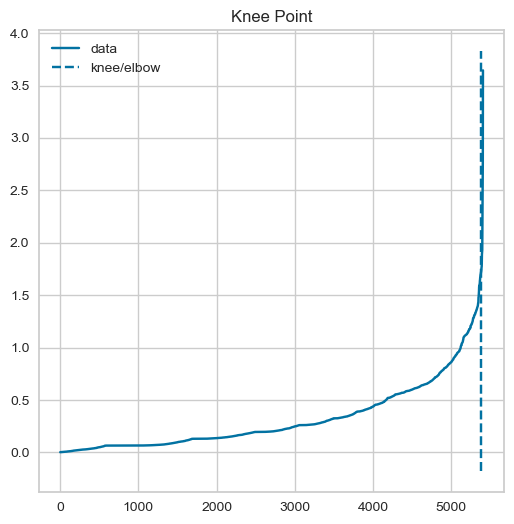

In [63]:
#Visualizing the knee point
kneedle.plot_knee()
plt.show()

Creating the final DBSCAN model with the epsilon found.

In [64]:
#DBSCAN final model
dbscan = DBSCAN(eps = 1.704, min_samples = min_samples)
db_clusters_ImpFeatures = dbscan.fit_predict(df_scaled[most_important_features])
print('dbscan has created clusters:', list(set(db_clusters_ImpFeatures)))

dbscan has created clusters: [0, -1]


Having only one cluster shows that epsilon might be too large so we will try to reduce it to get more clusters.

In [65]:
#DBSCAN final model with a lower epsilon 
dbscan = DBSCAN(eps = 1.25, min_samples = min_samples)
db_clusters_ImpFeatures = dbscan.fit_predict(df_scaled[most_important_features])
print('dbscan has created clusters:', list(set(db_clusters_ImpFeatures)))

dbscan has created clusters: [0, 1, 2, 3, -1]


## Model evaluation

We evaluate the model by using the Silhouette Score and the Davies-Bouldin Score.

1. **Silhouette Score**: This metric calculates the average distance between each sample in a cluster and all other points in the same cluster (cohesion), as well as the average distance between each sample in a cluster and the samples in the next nearest cluster (separation). The Silhouette Score ranges from -1 to 1, where a high value indicates that the sample is well matched to its own cluster and poorly matched to neighboring clusters.

2. **Davies-Bouldin Score**: This metric is an internal evaluation method where a lower Davies-Bouldin index relates to a model with better separation between the clusters. This index signifies the average 'similarity' between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. 

By calculating these scores for the DBSCAN on Principal components and important features, we can evaluate how well the DBSCAN has performed in creating distinct and meaningful clusters from the data.

In [66]:
#Metrics from imporant PC features method for DBSCAN
sc.append(metrics.silhouette_score(pca_comps, db_clusters_PCs, metric='euclidean'))
dbi.append(metrics.davies_bouldin_score(pca_comps, db_clusters_PCs))
clustering_methods.append('DBSCAN_on_PCs')

#metrics from imporant features from PCA method for DBSCAN
sc.append(metrics.silhouette_score(df_scaled[most_important_features], db_clusters_ImpFeatures, metric='euclidean'))
dbi.append(metrics.davies_bouldin_score(df_scaled[most_important_features], db_clusters_ImpFeatures))
clustering_methods.append('DBSCAN_on_ImpFeatures')

#Creating a pandas dataframe to see the results
d = {'silhouette_score': sc, 'DBI': dbi, 'clusteting_methods':clustering_methods}
df_metrics = pd.DataFrame(d)
df_metrics.set_index('clusteting_methods', inplace = True)
df_metrics

,silhouette_score,DBI
clusteting_methods,,
Kmean_on_PCs,0.209544,1.351548
Kmean_on_ImpFeatures,0.286299,1.164633
DBSCAN_on_PCs,0.205010,1.529999
DBSCAN_on_ImpFeatures,0.176781,2.071032


In regard to DBSCAN, we can see that DBSCAN on pricipal components performed better than iportant features with a higher Silhoutee score and lower DBI.

## Conclusion

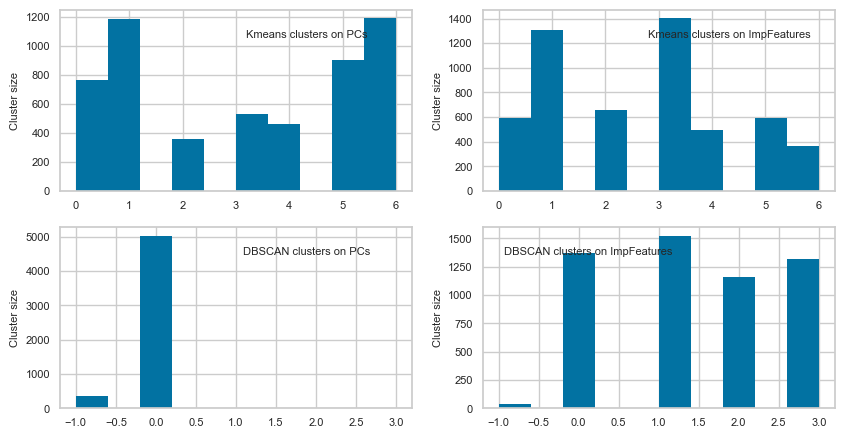

In [67]:
#Plotting the clusters for both Kmeans and DBSCAN

gs = gridspec.GridSpec(3,2)
fig = plt.figure(figsize=(10, 8), dpi=100)
ax1=fig.add_subplot(gs[0,0])
ax2=fig.add_subplot(gs[0,1])
ax3=fig.add_subplot(gs[1,0])
ax4=fig.add_subplot(gs[1,1])

#Plotting the clusters for both Kmeans PCs
ax1.hist(Kmeans_clusters_PCs)
ax1.set_title('Kmeans clusters on PCs', fontsize = 8, x=0.7, y=0.8)
ax1.set_ylabel('Cluster size', fontsize = 8)
ax1.tick_params(axis='both', which='major', labelsize=8)

#Plotting the clusters for both Kmeans ImpFeatures
ax2.hist(Kmeans_clusters_ImpFeatures)
ax2.set_title('Kmeans clusters on ImpFeatures', fontsize = 8, x=0.7, y=0.8)
ax2.set_ylabel('Cluster size', fontsize = 8)
ax2.tick_params(axis='both', which='major', labelsize=8)

#Plotting the clusters for both DBSCAN PCs
ax3.hist(db_clusters_PCs)
ax3.set_title('DBSCAN clusters on PCs', fontsize = 8, x=0.7, y=0.8)
ax3.set_ylabel('Cluster size', fontsize = 8)
ax3.tick_params(axis='both', which='major', labelsize=8)

#Plotting the clusters for both DBSCAN ImpFeatures
ax4.hist(db_clusters_ImpFeatures)
ax4.set_title('DBSCAN clusters on ImpFeatures', fontsize = 8, x=0.3, y=0.8)
ax4.set_ylabel('Cluster size', fontsize = 8)
ax4.tick_params(axis='both', which='major', labelsize=8)

Based on the the Silhouette score and Davies-Bouldin index, as well as looking at how the clusters are positioned. We can see that the K-means on important features performs best out of all the models.

## Cluster summary

So we take the K-means clustering on important features as the best model because it performs best in the Silhoutte score and Davies-Bouldin Index.

In [68]:
#We take the Kmeans_on_ImpFeatures as the best performing model.
#Adding the cluster column to the original dataset
eda_df['Cluster'] = Kmeans_clusters_ImpFeatures
eda_df.head()

,runtime,genre,worldwide_box_office,theatre_count,avg_run_per_theatre,creative_type,seasons,Cluster
0,104.0,1,108286422.0,3391.0,4.9,1,2,1
1,100.0,2,987640.0,3.0,2.1,1,4,3
2,93.0,2,307.0,819.5,4.2,1,1,1
3,93.0,2,47019.0,819.5,4.2,1,2,1
4,107.0,2,143782.0,6.0,3.8,2,3,3


We also recode the genre column and the creative type column to their original values. This can help us better understand the characteristics of each cluster, which is crucial for interpreting the results of a clustering analysis.



In [69]:
#We recode the genre column to the original values
#Defining a mapping of genre numbers to genre names
genre_mapping = {
    1: 'Thriller',
    2: 'Drama',
    3: 'Action',
    4: 'Horror',
    5: 'Documentary',
    6: 'Comedy',
    7: 'Romantic Comedy',
    8: 'Black Comedy',
    9: 'Western',
    10: 'Adventure',
    11: 'Musical',
    12: 'Multiple Genres',
    13: 'Concert'
}

#We take our list of genre numbers
genre_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

#Recode genre numbers to genre names
genre_names = [genre_mapping[num] for num in genre_numbers]

print(genre_names)


['Thriller', 'Drama', 'Action', 'Horror', 'Documentary', 'Comedy', 'Romantic Comedy', 'Black Comedy', 'Western', 'Adventure', 'Musical', 'Multiple Genres', 'Concert']


In [70]:
# Replace numbers with mapped genre names in the df
eda_df['genre'] = eda_df['genre'].map(genre_mapping)

eda_df


,runtime,genre,worldwide_box_office,theatre_count,avg_run_per_theatre,creative_type,seasons,Cluster
0,104.0,Thriller,108286422.0,3391.0,4.9,1,2,1
1,100.0,Drama,987640.0,3.0,2.1,1,4,3
2,93.0,Drama,307.0,819.5,4.2,1,1,1
3,93.0,Drama,47019.0,819.5,4.2,1,2,1
4,107.0,Drama,143782.0,6.0,3.8,2,3,3
...,...,...,...,...,...,...,...,...
5401,102.0,Comedy,55348693.0,3394.0,2.8,1,1,1
5402,83.0,Adventure,2784.0,819.5,4.2,1,3,3
5403,83.0,Adventure,12506188.0,2501.0,2.6,9,3,0
5404,96.0,Adventure,2784.0,819.5,4.2,1,4,3


In [71]:
#We recode the creative_type column to the original values
#Defining a mapping of creative type numbers to creative type names
creative_type_mapping = {
    1: 'Contemporary Fiction',
    2: 'Dramatization',
    3: 'Historical Fiction',
    4: 'Factual',
    5: 'Science Fiction',
    6: 'Fantasy',
    7: 'Kids Fiction',
    8: 'Multiple Creative Types',
    9: 'Super Hero',
}

# Replacing numbers with creative type names in the df
eda_df['creative_type'] = eda_df['creative_type'].map(creative_type_mapping)

eda_df


,runtime,genre,worldwide_box_office,theatre_count,avg_run_per_theatre,creative_type,seasons,Cluster
0,104.0,Thriller,108286422.0,3391.0,4.9,Contemporary Fiction,2,1
1,100.0,Drama,987640.0,3.0,2.1,Contemporary Fiction,4,3
2,93.0,Drama,307.0,819.5,4.2,Contemporary Fiction,1,1
3,93.0,Drama,47019.0,819.5,4.2,Contemporary Fiction,2,1
4,107.0,Drama,143782.0,6.0,3.8,Dramatization,3,3
...,...,...,...,...,...,...,...,...
5401,102.0,Comedy,55348693.0,3394.0,2.8,Contemporary Fiction,1,1
5402,83.0,Adventure,2784.0,819.5,4.2,Contemporary Fiction,3,3
5403,83.0,Adventure,12506188.0,2501.0,2.6,Super Hero,3,0
5404,96.0,Adventure,2784.0,819.5,4.2,Contemporary Fiction,4,3


Once the variables have reverted to the original values, we plot the features in the dataset per cluster so we can understand the characteristics of each cluster and also compare them.

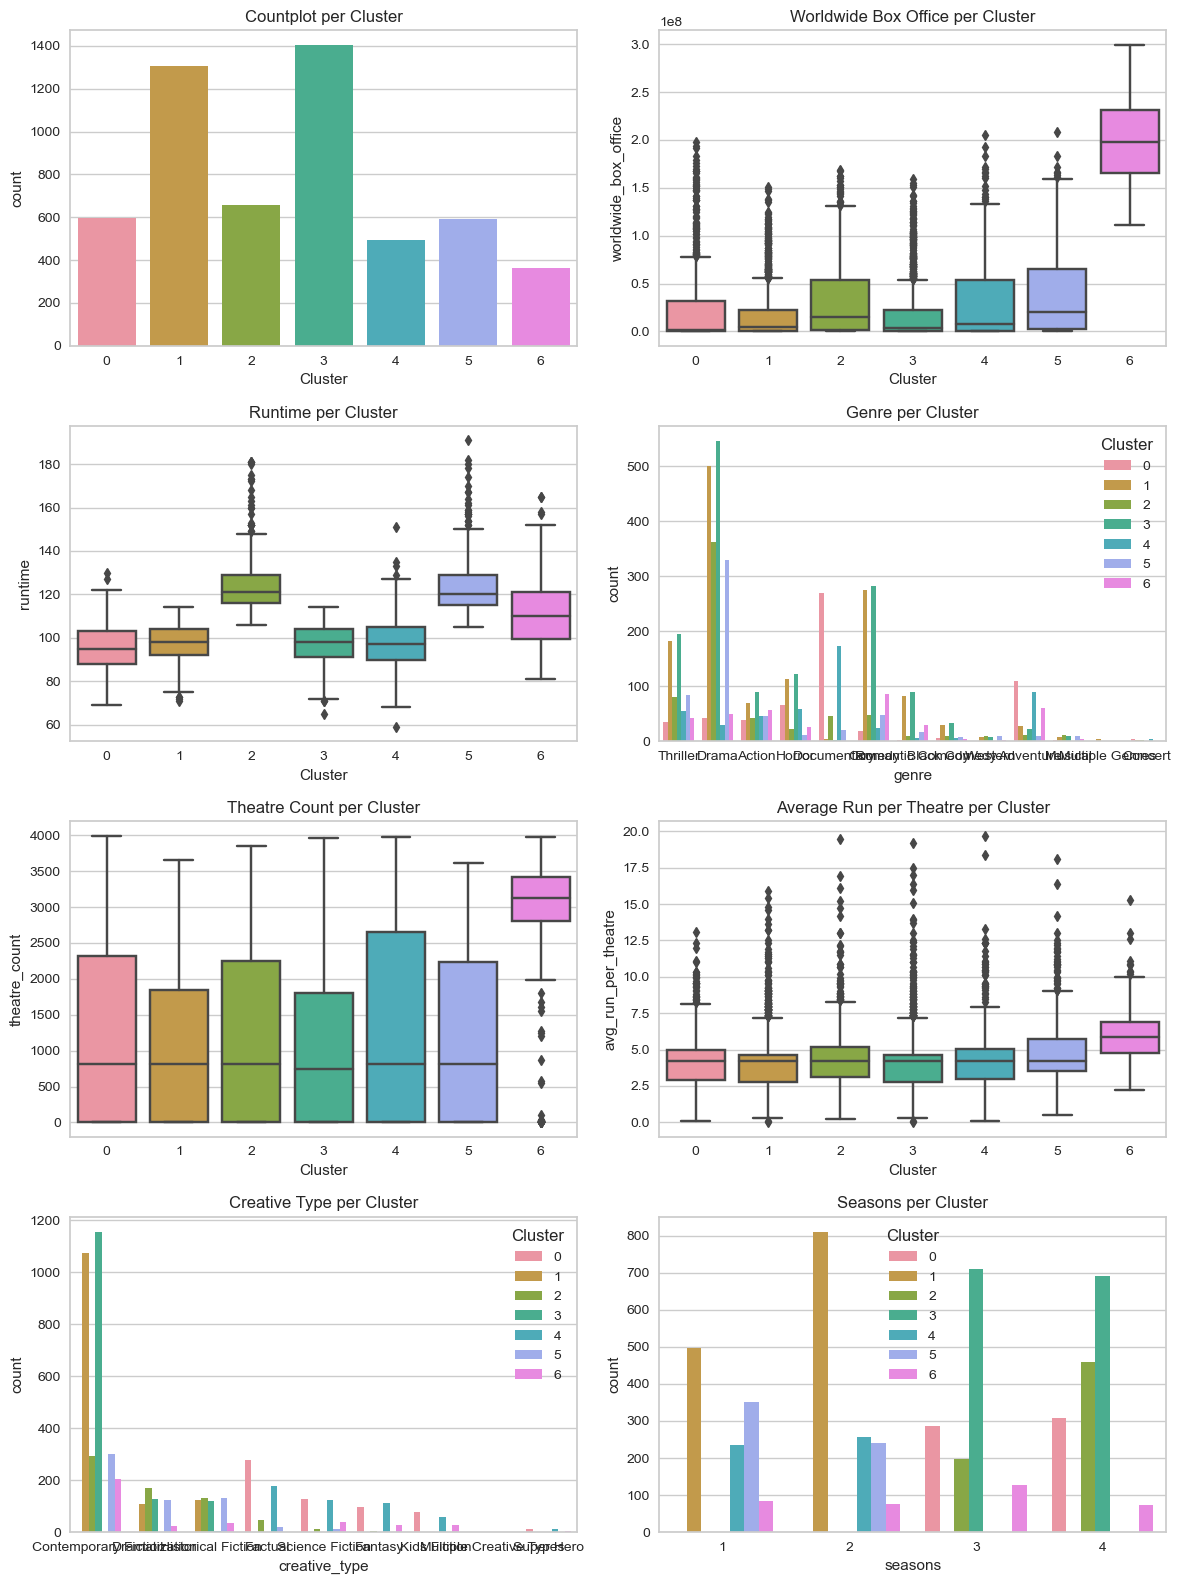

In [72]:
#Now we plot the features in the dataset per cluster

#Creating a subplot grid with 4 rows and 2 columns
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

#Plottin countplot per cluster
axs[0, 0].set_title('Countplot per Cluster')
sns.countplot(x='Cluster', data=eda_df, ax=axs[0, 0])

#Plotting worldwide box_office per cluster
axs[0, 1].set_title('Worldwide Box Office per Cluster')
sns.boxplot(x='Cluster', y='worldwide_box_office', data=eda_df, ax=axs[0, 1])

#Plotting runtime per cluster
axs[1, 0].set_title('Runtime per Cluster')
sns.boxplot(x='Cluster', y='runtime', data=eda_df, ax=axs[1, 0])

#Plotting genre per cluster
axs[1, 1].set_title('Genre per Cluster')
sns.countplot(x='genre', hue='Cluster', data=eda_df, ax=axs[1, 1])

#Plotting theatre count per cluster
axs[2, 0].set_title('Theatre Count per Cluster')
sns.boxplot(x='Cluster', y='theatre_count', data=eda_df, ax=axs[2, 0])

#Plotting average run per theatre per cluster
axs[2, 1].set_title('Average Run per Theatre per Cluster')
sns.boxplot(x='Cluster', y='avg_run_per_theatre', data=eda_df, ax=axs[2, 1])

#Plotting creative type per cluster
axs[3, 0].set_title('Creative Type per Cluster')
sns.countplot(x='creative_type', hue='Cluster', data=eda_df, ax=axs[3, 0])

#Plotting seasons per cluster
axs[3, 1].set_title('Seasons per Cluster')
sns.countplot(x='seasons', hue='Cluster', data=eda_df, ax=axs[3, 1])

#Adjusting the spacing between subplots
plt.tight_layout()

#Showing the plot
plt.show()


### Cluster descriptions.

**Cluster 0**: Featuring a relatively low worldwide box office and the shortest runtime, this cluster has a median runtime of around 95 minutes. Documentaries and adventure films are prevalent genres. Theatre count and average run per theatre are average. Notably, the creative types include a high proportion of factual and science fiction movies (main characteristic), along with substantial representation in fantasy and kid fiction. Releases are confined to summer or autumn.

**Cluster 1**: With one of the lowest worldwide box office scores, this cluster features a runtime close to 100 minutes on average. Drama, thriller, and comedy are the dominant genres. Theatre count and average run per theatre are both low. Contemporary fiction is the prevailing creative type. Notably, it has most releases occur in winter and spring out of all clusters (main characteristics).

**Cluster 2:** With an average worldwide box office compared to other clusters, this group has the second-highest runtime, around 120 minutes (main characteristic). Drama is the dominant genre. Theatre count and average run per theatre are both average. Creative types are primarily contemporary fiction and dramatization. Releases are limited to summer or autumn.

**Cluster 3**: This cluster exhibits one of the lowest worldwide box office scores. The runtime tends to be relatively short, with a median close to 100 minutes. The predominant genres are drama, comedy, and thriller, with a low theatre count and average runs per theatre. The creative type leans towards contemporary fiction. Notably, movies in this cluster are have the highest amount of releases out of any cluster in summer or autumn (main characteristic).

**Cluster 4**: While the worldwide box office is average compared to other clusters, the median value is low. Movies in this cluster typically have a runtime close to 100 minutes. Documentaries dominate the genre, followed by adventure films. The theatre count is second highest, though the average run per theatre is average. The creative type is factual, aligning well with the documentary genre. Releases are exclusive to winter or spring.

**Cluster 5**: The second-highest worldwide box office is one of the distinctive features of this cluster. The runtime is the longest among clusters, with a median of around 120 minutes (main characteristic). Drama and comedy are the prominent genres. Theatre count is average, and the average run per theatre is the second highest. Creative types include contemporary fiction, dramatization, and historical fiction. Releases are exclusive to winter or spring.

**Cluster 6**: This cluster boasts the highest worldwide box office performance (main characteristic). The runtime is average, around 110 minutes. Genres are evenly distributed. Theatre count is the highest among clusters, and the average run per theatre is also slightly higher. Creative types are equally distributed with a slight preference for contemporary fiction. Releases span across all seasons.

## Answering my research questions

As a reminder, these were my research questions:

**"What type of movie clusters are most successful for studios to make?"**

•	What type of movie clusters are most attractive for theaters to widely release the film?

•	What type of movie clusters are most attractive for theaters to keep it running for longer?

•	How does a length of a movie influence overall worldwide box office within clusters?

•	How does season of release influence overall worldwide box office within clusters?

•	How does creative type influence overall worldwide box office within clusters?

•	Which model (K-means, DBSCAN) works best?

For the main research question, we can say that, for studios, the most successful movies to make in terms of box office are from clusters 5 and 6. This means that the runtime of the movie should be on average over 110 minutes. In addition, the theatre count and avg run per theatre should both be high. Moreover, Creative type should lean towards contemporary fiction.

As for the subquestions relevant for theatres, we find that clusters 4,5,6 perform well in both theatre count and average run per theatre. So for the movies to perform in many theaters and for a long time, the worldwide box offcie score is important (the bigger the better). Additionally, there is an overlap in that the movies have released in winter or spring predominantly. This is an interesting insight because it could be that with the bad weather the theatres keep the movies running longer and in more places.

In terms of the other subquestions, we can see that in terms of the leghtn of the movie, it should be over 110 minutes for a bigger box office result. As for the season of release, it doesn't seem to play that big of a role when looking at the clusters. As ford the creative type of the movie, contemporary fition seems to do the best.

For the last subquestion, we found that the K-means clustering on important features performed the best out of all models. 